In [1]:
# solving Lorenz inverse equation

In [2]:
import torch

In [3]:
torch.cuda.is_available()

True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10833703969508438780
xla_global_id: -1
]


In [2]:
# get the data
def get_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]

In [3]:
# define the lorenz PDE output
def lorenz(x, y, z, rho, sigma, beta):
    dxdt = rho * (y - x)
    dydt = x * (sigma - z) - y
    dzdt = x * y - beta * z

    return dxdt, dydt, dzdt

In [4]:
# here's a feedforward neural network -> change the architecture when you're ready
# import necessary modules
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dense, Input


class DenseBlock(tf.keras.Model):
    def __init__(self, layers, layer_width, bn=False, name="encoder"):
        """
        Creates a sequence of equal width dense layers
        :param layers: number of dense layer repetitions
        :param layer_width: number of neurons per dense layer
        """
        # supercharge
        super(DenseBlock, self).__init__()

        # operations
        self.dense = self._make_dense(layers, layer_width, bn, name)

    @staticmethod
    def _make_dense(layers, layer_width, bn, name, init="glorot_uniform"):
        input_shape = Input(shape=(1,), name="input")
        x = input_shape

        for i in range(layers):
            x = Dense(
                layer_width,
                activation="tanh",
                kernel_initializer=init,
                name="dense_{}".format(i + 1),
            )(x)
            if bn:
                x = BatchNormalization(name="bn_{}".format(i + 1))(x)

        y1 = Dense(1, kernel_initializer=init, name="y1")(x)
        y2 = Dense(1, kernel_initializer=init, name="y2")(x)
        y3 = Dense(1, kernel_initializer=init, name="y3")(x)

        return tf.keras.Model(inputs=input_shape, outputs=[y1, y2, y3], name=name)

    def call(self, x):
        return self.dense(x)

In [5]:
def get_lorenz():
    # data = get_traindata()

    # initial conditions
    # this is where the system is at at time 0
    x0 = -8
    y0 = 7
    z0 = 27

    # true solutions
    rhogt = 10
    sigmagt = 15
    betagt = 8/3
    

    # we want the PDE to find the solutions of the parameters
    # so it can effectively reproduce the system of x, y, z over time

    dt = 0.01
    num_steps = 1000

    ts, xs, ys, zs = [0], [x0], [y0], [z0]

    # stepping through time steps to get PDE solution
    for i in range(num_steps):
        dxdt, dydt, dzdt = lorenz(xs[i], ys[i], zs[i], rhogt, sigmagt, betagt)

        xs.append(xs[i] + dxdt * dt)
        ys.append(ys[i] + dydt * dt)
        zs.append(zs[i] + dzdt * dt)
        ts.append(ts[i] + dt)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Ground-Truth", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

    return ts, xs, ys, zs

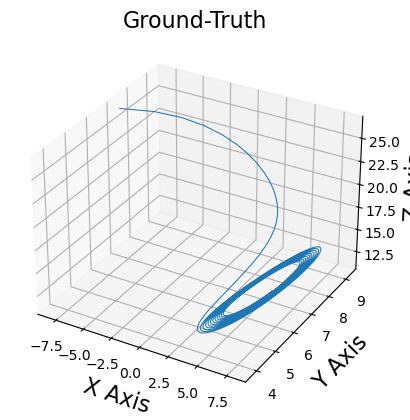

([0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.060000000000000005,
  0.07,
  0.08,
  0.09,
  0.09999999999999999,
  0.10999999999999999,
  0.11999999999999998,
  0.12999999999999998,
  0.13999999999999999,
  0.15,
  0.16,
  0.17,
  0.18000000000000002,
  0.19000000000000003,
  0.20000000000000004,
  0.21000000000000005,
  0.22000000000000006,
  0.23000000000000007,
  0.24000000000000007,
  0.25000000000000006,
  0.26000000000000006,
  0.2700000000000001,
  0.2800000000000001,
  0.2900000000000001,
  0.3000000000000001,
  0.3100000000000001,
  0.3200000000000001,
  0.3300000000000001,
  0.34000000000000014,
  0.35000000000000014,
  0.36000000000000015,
  0.37000000000000016,
  0.38000000000000017,
  0.3900000000000002,
  0.4000000000000002,
  0.4100000000000002,
  0.4200000000000002,
  0.4300000000000002,
  0.4400000000000002,
  0.45000000000000023,
  0.46000000000000024,
  0.47000000000000025,
  0.48000000000000026,
  0.49000000000000027,
  0.5000000000000002,
  0.5100000000000002,
 

In [6]:
get_lorenz()

In [7]:
def mse_loss(u_true, y_pred):

    loss_x = tf.reduce_mean(tf.square(y_pred[0] - u_true[0]))
    loss_y = tf.reduce_mean(tf.square(y_pred[1] - u_true[1]))
    loss_z = tf.reduce_mean(tf.square(y_pred[2] - u_true[2]))
    loss_fx = tf.reduce_mean(tf.square(y_pred[3]))
    loss_fy = tf.reduce_mean(tf.square(y_pred[4]))
    loss_fz = tf.reduce_mean(tf.square(y_pred[5]))

    # larger weight given to incorrect x, y, and z terms
    # since this is an inverse problem, we add loss due to parameter terms
    return 10*(loss_x+loss_y+loss_z) + (loss_fx+loss_fy+loss_fz)

In [26]:
def train_lorenz(epochs=1000):

    ts, xs, ys, zs = get_lorenz()

    # convert to tf tensors
    ts = tf.convert_to_tensor(ts, dtype=tf.float32)
    xs = tf.convert_to_tensor(xs, dtype=tf.float32)
    ys = tf.convert_to_tensor(ys, dtype=tf.float32)
    zs = tf.convert_to_tensor(zs, dtype=tf.float32)


    # ts = np.array(ts)
    # xs = np.array(xs)
    # ys = np.array(ys)
    # zs = np.array(zs)

    # now we are training

    NN = DenseBlock(layers=3, layer_width=32, bn=True)
    epochs = epochs

    # optimizer
    optimizer = tf.optimizers.Adam(learning_rate=1e-2)

    # initializing parameters
    rho = tf.Variable(1.0, trainable=True)
    sigma = tf.Variable(1.0, trainable=True)
    beta = tf.Variable(1.0, trainable=True)

    # loss function
    loss_fn = mse_loss

    # training loop
    for epoch in range(epochs):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(ts)
            # forward pass
            y_pred = NN(ts)

            x, y, z = y_pred[0], y_pred[1], y_pred[2]

            # finding the gradient with automatic differentiation
            dxdt = tape.gradient(x, ts)
            dydt = tape.gradient(y, ts)
            dzdt = tape.gradient(z, ts)

            rx = dxdt - rho * (y - x)
            ry = dydt - x * (sigma - z) + y
            rz = dzdt - x * y - beta * z

            y_pred = [x, y, z, rx, ry, rz]

            # calculate loss
            loss = loss_fn([xs, ys, zs], y_pred)

            print(loss.numpy().item())

            # tape grads
            # TODO: fix this so it works for tensorflow 2.0

            grads = tape.gradient(loss, [rho, sigma, beta] + NN.trainable_variables)
        optimizer.apply_gradients(zip(grads, [rho, sigma, beta] + NN.trainable_variables))
        
        # optimizer.minimize(loss=loss, var_list=[rho, sigma, beta, NN.trainable_variables])

    tf.saved_model.save(NN, "lorenz_inverse_0.1")

    # ground truth figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Ground-Truth", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

    # learned figure
    fig = plt.figure()

    # predict curve
    output = NN(ts)
    x_pred, y_pred, z_pred = output[0], output[1], output[2]
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x_pred, y_pred, z_pred, lw=.75)
    ax.set_xlabel("X Axis", fontsize=16)
    ax.set_ylabel("Y Axis", fontsize=16)
    ax.set_zlabel("Z Axis", fontsize=16)
    ax.set_title("Learned", fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=10,pad=2)
    ax.tick_params(axis='both', which='minor', labelsize=8,pad=2)
    plt.show()

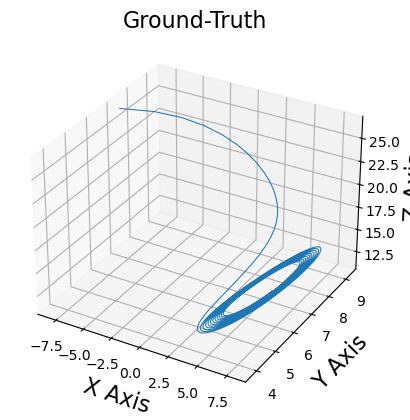

2540.62060546875
2014.781494140625
1666.330810546875
1474.52099609375
1377.508056640625
1294.101318359375
1195.683837890625
1092.398681640625
1003.8260498046875
938.415283203125
889.5291137695312
846.6220703125
802.7166137695312
755.3363037109375
706.4126586914062
661.160888671875
625.4429931640625
602.3577270507812
589.5730590820312
580.8131103515625
572.5159301757812
567.2132568359375
568.8194580078125
575.1514892578125
578.837646484375
577.5234375
575.484619140625
575.5203247070312
574.4052734375
568.7203369140625
560.553466796875
553.712158203125
548.4114990234375
542.3616943359375
535.1197509765625
528.5464477539062
523.9613037109375
520.6868896484375
517.4310913085938
514.0089721679688
511.16131591796875
509.29168701171875
507.93682861328125
506.3913269042969
504.48388671875
502.58221435546875
500.9944152832031
499.57061767578125
497.9288024902344
495.9409484863281
493.85052490234375
491.9233703613281
490.12347412109375
488.22869873046875
486.1879577636719
484.21392822265625
482.

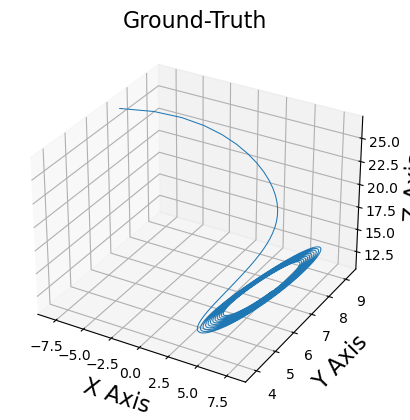

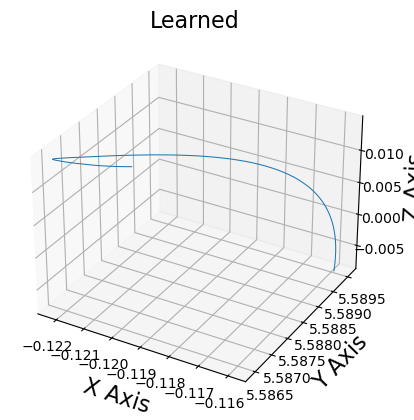

In [27]:
train_lorenz(epochs=10000)